# Bayesian Optimization with Gaussian Processes

---

# Gaussian Basics

> $$X_i \sim \mathcal N \left( 0, 1\right)$$

To get different values for the mean and variance:

> $$Y_i \sim \mathcal N \left( \mu, \sigma^2\right)$$

>
> $$Y_i \sim \mu + \sigma \ \mathcal N \left( 0, 1\right)$$

So

> $$Y_i = \mu + \sigma X_i \sim \mathcal N \left( \mu, \sigma^2\right)$$

### More dimensions

We have
> $$\left[\begin{matrix}X_1\\
X_2\end{matrix}\right]_i 
\sim N \left(\left[\begin{matrix}0\\
0\end{matrix}\right],
\left[\begin{matrix}1&0\\
0&1\end{matrix}\right]\right)$$


We want
>$$\left[\begin{matrix}Y_1\\
Y_2\end{matrix}\right]_i 
\sim N \left(\left[\begin{matrix}\mu_1\\
\mu_2\end{matrix}\right],
\left[\begin{matrix}\Sigma_{11}&\Sigma_{12}\\
\Sigma_{21}&\Sigma_{22}\end{matrix}\right]\right)$$

* Sum to get the right means.

* Multiply by $L$ to get the covariance matrix $\mathbf \Sigma$ , where $L$ is one of the terms of the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\mathbf \Sigma$ 
$$\left[\begin{matrix}Y_1\\
Y_2\end{matrix}\right]_i 
= \left[\begin{matrix}\mu_1\\
\mu_2\end{matrix}\right] + L \left[\begin{matrix}X_1\\
X_2\end{matrix}\right]_i $$

Where
> $$\mathbf \Sigma = LL^T$$

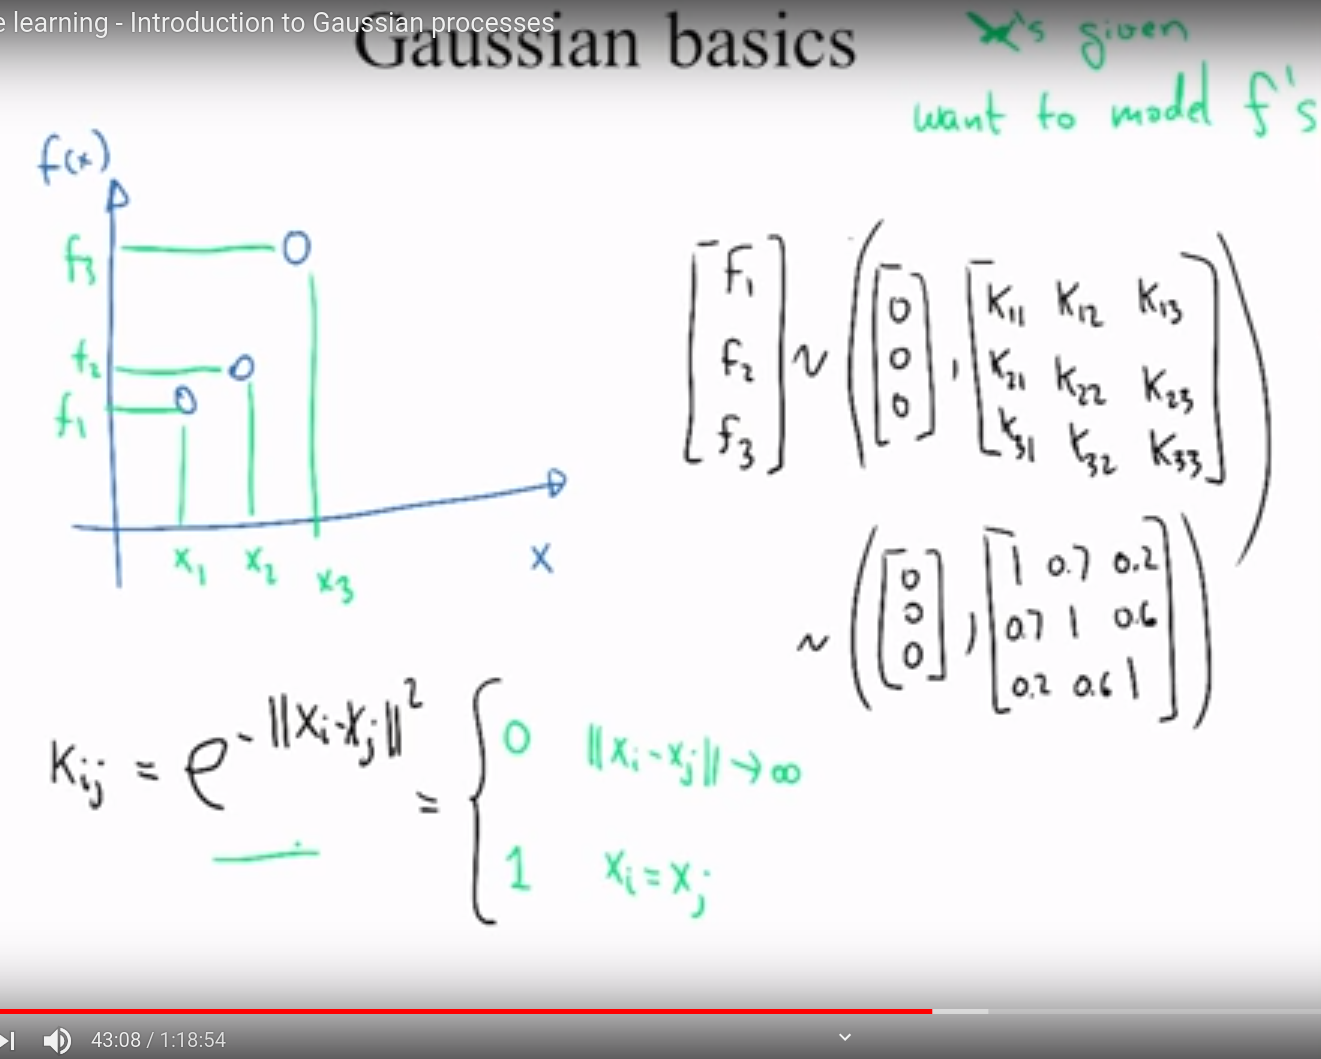

>If we construct a ***matrix of similarities*** $\mathbf K$ using some measure of distance between $X_i$ points
>
>and we use it as the ***covariance matrix*** $\mathbf \Sigma$ for constructing $ N(\mathbf 0, \mathbf K) \approx N(\mathbf 0, \mathbf \Sigma)$
>
>we will have a **model** that makes **good predictions** of the height $f_i$
>
> not only for the points used to construct $\mathbf K$
>
> BUT for ***any new point, or set of points*** $\mathbf X_{test}$

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist

### Squared Exponential Kernel

> $$\large K_{ij} = e^{-||X_i - X_j||^2}$$

In [195]:
def sqexp_kernel(x1, x2):
    'Returns exp(-||x1,x2||**2) forall xi,xj'
    d = dist.cdist(x1, x2, 'sqeuclidean')
    K = np.exp(-d**2)
    return K

In [196]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

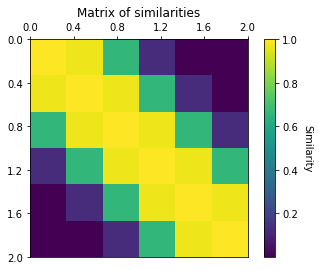

Input data X = 
[[0. ]
 [0.4]
 [0.8]
 [1.2]
 [1.6]
 [2. ]]

Matrix K = 
[[1.00  0.97  0.66  0.13  0.00  0.00]
 [0.97  1.00  0.97  0.66  0.13  0.00]
 [0.66  0.97  1.00  0.97  0.66  0.13]
 [0.13  0.66  0.97  1.00  0.97  0.66]
 [0.00  0.13  0.66  0.97  1.00  0.97]
 [0.00  0.00  0.13  0.66  0.97  1.00]]


In [197]:
X = np.linspace(0, 2, 6)[:, np.newaxis]

K = sqexp_kernel(X, X)
ax = plt.gca()
im = ax.imshow(K, extent=[0, 2, 2, 0])
ax.set_title('Matrix of similarities')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Similarity', rotation=-90, va="bottom")

ax.set_xticks(X, minor=False)
ax.set_yticks(X, minor=False)

plt.show()


print("Input data X = \n{}\n".format(X))
print("Matrix K = \n{}".format(np.array2string(K, precision=2, separator="  ",
                                  formatter={'float_kind':lambda x: "%.2f" % x})))

In [198]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

### Noiseless GP Regression

$$\left(\begin{matrix} \mathbf f\\\mathbf f_* \end{matrix}\right)
\sim
\mathcal N \left( \left(
\begin{matrix} \mu\\\mu_* 
\end{matrix}\right) , \left(
\begin{matrix} \mathbf K&\mathbf K_*\\\mathbf K_*^T&\mathbf K_{**} 
\end{matrix}\right)\right)$$

where
> $\mathbf K = \kappa (X, X)$ is $N\times N$
>
> with $\kappa(X, X) :=$ Kernel distance between ***training points***

> $\mathbf K_* = \kappa (X, X_*)$ is $N\times N_*$
>
> with $\kappa(X, X_*) :=$ Kernel distance between ***training points*** and ***new points***

> $\mathbf K_{**} = \kappa (X_*, X_*)$ is $N_*\times N_*$
>
> with $\kappa(X_*, X_*) :=$ Kernel distance between ***new points***

$$\left(\begin{matrix} \mathbf f\\\mathbf f_* \end{matrix}\right)
\sim
\mathcal N \left(
\begin{matrix} 0 
\end{matrix} , \left(
\begin{matrix} \left[
\begin{matrix} 
K_{11}&K_{12}&K_{12}\\ 
K_{21}&K_{22}&K_{23}\\
K_{31}&K_{32}&K_{33}\\
\end{matrix}\right]&\left[
\begin{matrix} 
K_{1*}\\
K_{2*}\\
K_{3*}
\end{matrix}\right]\\\left[
\begin{matrix}
K_{1*}&K_{2*}&K_{3*}
\end{matrix}\right]&\left[
\begin{matrix}
K_{**}
\end{matrix}\right] 
\end{matrix}\right)\right)$$

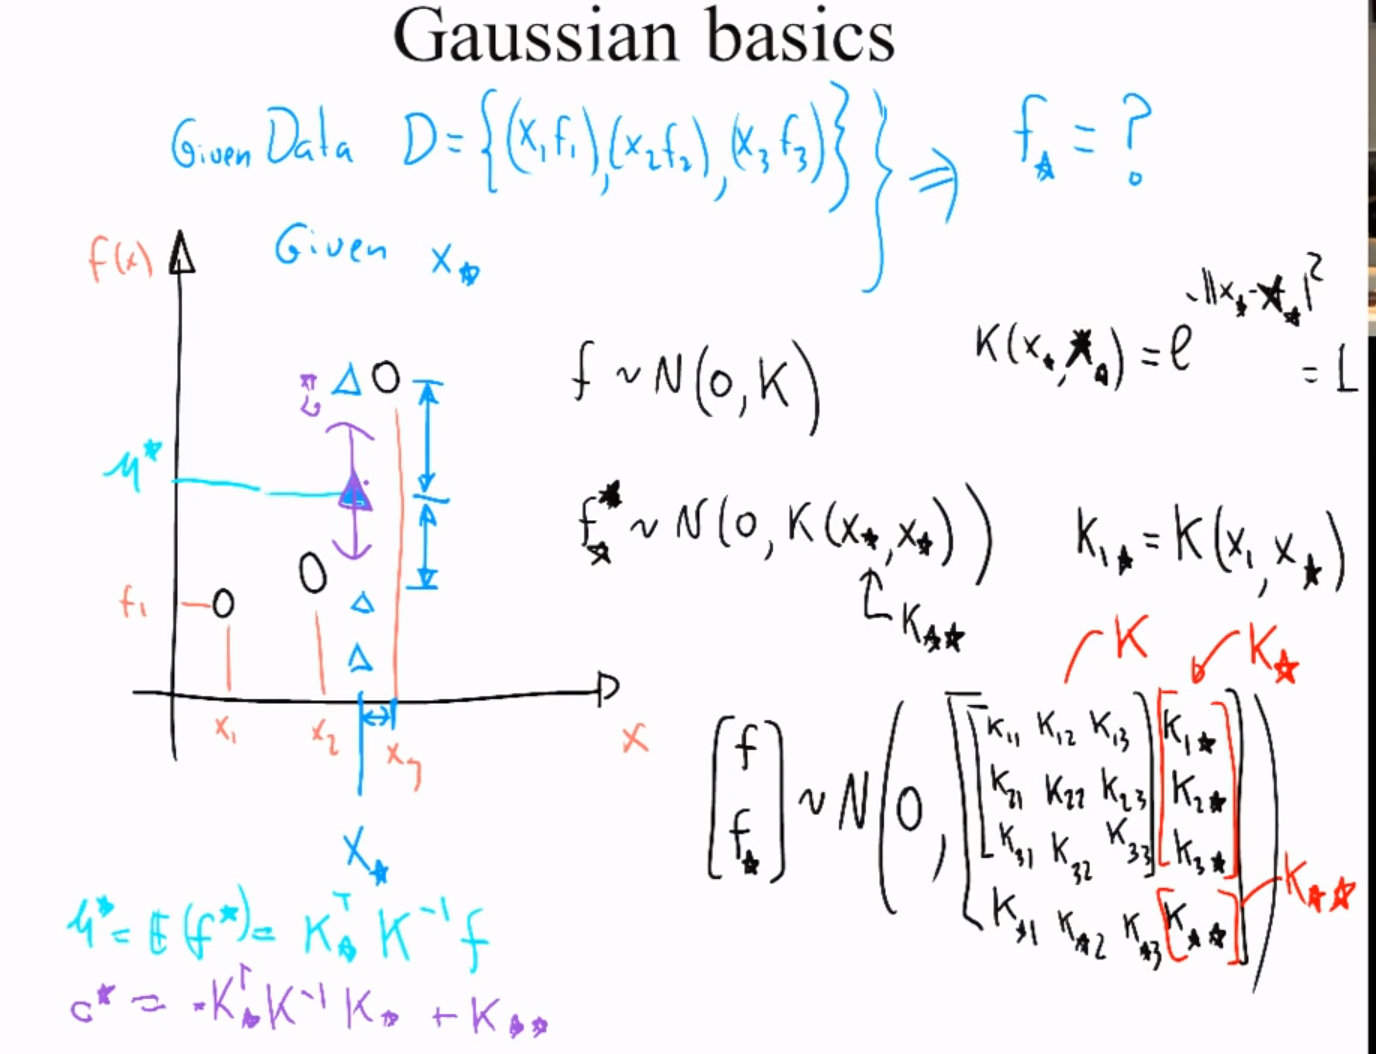

By Theorem, we know that for any new point $X_*$, we can estimate it's height $\mathbf f_*$ with a Normal distribution with mean $\mu_*$ and covariance $\sigma_*$

>$$\mu_* =  \mathbf E \left[\mathbf f_* \right] = \mathbf K_*^T \mathbf K^{-1} \mathbf f$$
>
>$$\sigma_* = \mathbf K_{**} - \mathbf K_*^T \mathbf K^{-1} \mathbf K_*$$

In [222]:
'''Starting code from:
https://github.com/cottrell/ipynb/blob/894ee9409f71aeb477dc9b635f3d49bc48152028/ml/GP.ipynb
Possibly from Nando's files for this Homework3, lost in time.'''

class GP:
    """ (n, d)-array xtrain and an n-vector ytrain """
    def __init__(self, kernel, sigma=1.0):
        self.kernel = kernel
        self.sigma  = sigma
        self.predict = self.posterior
        self.fit = self.add_data

In [223]:
class GP(GP):  
    def add_data(self, xtrain, ytrain):
        """ Append data, update mu and K """
        self.xtrain = xtrain # hstack(self.xtrain, xtrain)
        self.ytrain = ytrain # hstack(self.ytrain, ytrain)
        self.K  = self.kernel(self.xtrain, self.xtrain)
        K = self.K
        sigma = self.sigma
        I = np.eye(len(xtrain))
        # K + noise of y, where y = f(x)+noise
        self.Ky = K + sigma ** 2 * I

In [236]:
class GP(GP):    
    def posterior(self, xtest):
        """ Compute mu_star, K_star, sigma_star """
        Ks  = self.kernel(self.xtrain, xtest)
        Kss = self.kernel(xtest, xtest)
        
        Kyinv = np.linalg.inv(self.Ky)
        KKyT  = np.dot(Ks.T, Kyinv)
        
        mu = np.dot(KKyT, self.ytrain)
        Ss = Kss - np.dot(KKyT, Ks) 
        return mu, Ss

In [225]:
def sqexp_kernel_adv(x1, x2, ell=.5, sf2=1.0):
    """ x1 and x2 of size (n, d) and (m, d) """
    d = dist.cdist(x1, x2, 'sqeuclidean')
    k = sf2 * np.exp(-0.5 * d / ell)
    return k

In [246]:
#myGP = GP(sqexp_kernel, sigma=0.05)

In [297]:
m = 2
n = 1
X = np.random.normal(size=(m, n))
a = np.random.normal(size=n)
y = np.dot(X, a)


print("{}x{} random N(0,1) values".format(X.shape[0], X.shape[1]))
print("{} output values Xa".format(y.shape[0]))

2x1 random N(0,1) values
2 output values Xa


In [298]:
%matplotlib inline

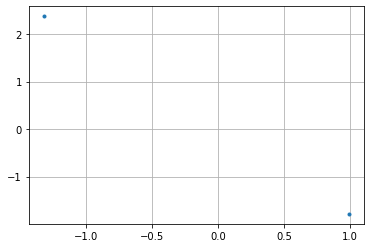

Points at:
P1: 0.9878, -1.786
P2: -1.315, 2.378


In [299]:
plt.plot(X, y, '.')
plt.grid()
plt.show()

print("Points at:")
print("P1: {:.4}, {:.4}".format(X[0][0],y[0]))
print("P2: {:.4}, {:.4}".format(X[1][0],y[1]))


In [300]:
gp = GP(sqexp_kernel, sigma=0.05)
gp.add_data(X, y)

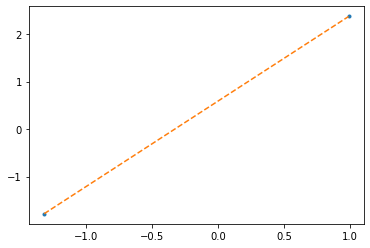

In [301]:
for i in range(X.shape[1]):
    x  = X[:,i]
    xx = X[:,i].copy()
    ia = xx.argsort()
    xx = np.atleast_2d(np.linspace(x.min(), x.max(), m)).T
    yy = np.atleast_2d(np.linspace(y.min(), y.max(), m)).T
    yp, Ss = gp.posterior(X)
    plt.plot(xx, y, '.')
    plt.errorbar(xx, yp, yerr=np.diag(Ss), linestyle="--")
plt.show()

In [302]:
yp, s2 = gp.posterior(X)
print("Mean posterior: ", yp)
print("Variance: ", s2)

Mean posterior:  [-1.78145985  2.37196672]
Variance:  [[2.49376559e-03 3.78137775e-18]
 [3.78137775e-18 2.49376559e-03]]


In [303]:
n_test = 100
Xtest = np.linspace(-5, 5, n_test).reshape(-1,1)

In [304]:
print("Points at:")
print("P1: {:.4}, {:.4}".format(X[0][0],y[0]))
print("P2: {:.4}, {:.4}".format(X[1][0],y[1]))

Points at:
P1: 0.9878, -1.786
P2: -1.315, 2.378


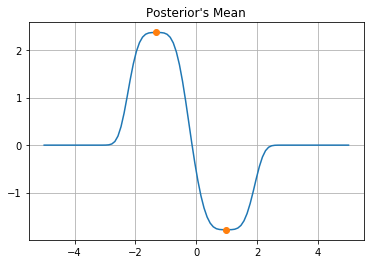

In [305]:
yp, Ss = gp.posterior(Xtest)
plt.plot(Xtest, yp)
plt.plot(X, y, marker="o",linestyle=" ")
plt.title("Posterior's Mean")
plt.grid()
plt.show()

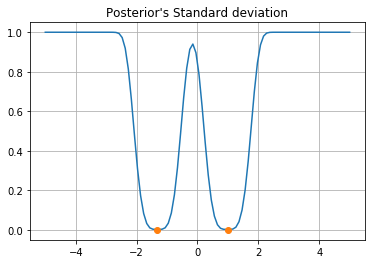

In [306]:
plt.plot(Xtest, np.diag(Ss))
plt.grid()
plt.plot(X, np.zeros(X.size), marker="o", linestyle=" ")
plt.title("Posterior's Standard deviation")
plt.show()

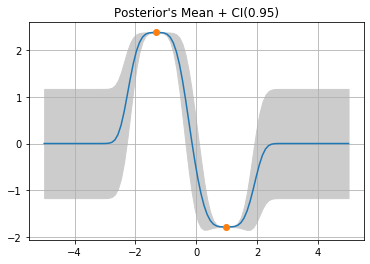

In [331]:
s = np.diag(Ss)
n = X.shape[0]
plt.plot(Xtest, yp)
plt.gca().fill_between(Xtest.flat, yp-1.65*s/np.sqrt(n), yp+1.65*s/np.sqrt(n), color="#cccccc")
plt.plot(X, y, marker="o",linestyle=" ")
plt.title("Posterior's Mean + CI(0.95)")
plt.grid()
plt.show()

In [315]:
K = gp.K

In [336]:
L = np.linalg.cholesky(K + 1.0*0.05*np.eye(2))
L

array([[1.02469508e+00, 0.00000000e+00],
       [5.93395379e-13, 1.02469508e+00]])

In [319]:
# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n_test).reshape(-1,1)

In [321]:
# compute the mean at our test points.
Lk = np.linalg.solve(L, gp.kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

In [327]:
Lk.shape

(2, 100)

In [332]:
# compute the variance at our test points.
Kss = gp.kernel(Xtest, Xtest)
s2 = np.diag(Kss) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

In [333]:
Kss.shape

(100, 100)

In [337]:
# draw samples from the posterior at our test points.
L = np.linalg.cholesky(Kss + 1e-5*np.eye(100) - np.dot(Lk.T, Lk))
n_samples = 1
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_test, n_samples)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')
pl.show()

LinAlgError: Matrix is not positive definite